In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,classification_report



In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("/Users/itobuz/Downloads/product_dataset.csv")

In [4]:
# Define time of day buckets
def time_of_day(hour):
    if hour < 12:
        return 0
    elif hour < 18:
        return 1
    elif hour < 22:
        return 2
    else:
        return 3
df['time_of_day'] = df['order_hour_of_day'].apply(time_of_day)
# Days Since Last Purchase
df['days_since_last_purchase'] = df.groupby(['user_id', 'product_id'])['days_since_prior_order'].shift(-1).fillna(0)
# Number of orders per user
df['user_order_count'] = df.groupby('user_id')['order_id'].transform('count')
# Sum of items ordered per order
df['total_items_ordered'] = df.groupby('order_id')['add_to_cart_order'].transform('sum')
# Total orders for each product
df['product_popularity'] = df.groupby('product_id')['order_id'].transform('count')
# Average order hour for each user
df['avg_order_hour'] = df.groupby('user_id')['order_hour_of_day'].transform('mean')
# Order Frequency
df['order_frequency'] = df.groupby(['user_id', 'product_id'])['order_id'].transform('count')
# Product Affinity by Department
df['department_affinity'] = df.groupby(['user_id', 'department_id'])['order_id'].transform('count') / df.groupby('user_id')['order_id'].transform('count')
# Time of Purchase Features
df['preferred_order_hour'] = df.groupby('user_id')['order_hour_of_day'].transform('mean')
df['preferred_order_dow'] = df.groupby('user_id')['order_dow'].transform('mean')
# Average Reorder Rate
df['avg_reorder_rate'] = df.groupby(['user_id'])['reordered'].transform('mean')
# Product Reorder Frequency (across all users)
df['product_reorder_frequency'] = df.groupby('product_id')['reordered'].transform('sum')
# User's Reorder Rate for Product
df['user_product_reorder_rate'] = df.groupby(['user_id', 'product_id'])['reordered'].transform('mean')
# Order Count for Product by User
df['user_product_order_count'] = df.groupby(['user_id', 'product_id'])['order_id'].transform('count')

1. **Time of Day Buckets**  
   - Categorizes the time of day into morning, afternoon, evening, and night.  
   - Helps capture user behavior patterns based on the time they place orders, improving product recommendations.

2. **Days Since Last Purchase**  
   - Calculates the number of days since the last purchase.  
   - Useful for understanding user purchase cycles and predicting products that may be due for reordering.

3. **Number of Orders per User**  
   - Tracks how many orders a user has placed.  
   - Indicates user engagement, helping to personalize future product recommendations.

4. **Sum of Items Ordered per Order**  
   - Measures the total number of items ordered in each transaction.  
   - Identifies bulk buying or diverse preferences, useful for recommending related items.

5. **Total Orders for Each Product**  
   - Counts the total number of times each product has been ordered.  
   - Highlights popular products, making them good candidates for recommendations.

6. **Average Order Hour for Each User**  
   - Calculates the average hour of day when a user places orders.  
   - Helps identify time-based preferences, allowing recommendations that align with the user’s ordering habits.

7. **Order Frequency**  
   - Tracks how often a user orders the same product.  
   - Indicates user preference and habit, key for identifying repeat purchases and cross-selling.

8. **Product Affinity by Department**  
   - Measures a user’s preference for different product departments.  
   - Helps recommend products based on a user's department preferences.

9. **Time of Purchase Features: Preferred Hour and Day of Week**  
   - Identifies the user's preferred time of day and day of the week for orders.  
   - Enhances temporal personalization by suggesting products at the right times for conversion.

10. **Average Reorder Rate**  
   - Measures the likelihood of a user reordering items.  
   - Important for predicting products the user is likely to reorder based on past behavior.

11. **Product Reorder Frequency (across all users)**  
   - Tracks how often a product is reordered across all users.  
   - Highlights products with a high likelihood of repeat purchases, useful for recommendations.

12. **User's Reorder Rate for Product**  
   - Measures the likelihood of a user reordering a specific product.  
   - Enhances personalized recommendations by focusing on products a user is likely to reorder.

13. **Order Count for Product by User**  
   - Calculates how many times a user has ordered a specific product.  
   - Identifies products with high user-specific engagement, useful for creating personalized recommendations.

In [5]:
# Function to perform target encoding
def target_encode(df, columns, target):
    encoded_df = df.copy()
    
    for col in columns:
        # Calculate the mean of target per category
        means = df.groupby(col)[target].mean()
        # Map the means to the respective column in the dataframe
        encoded_df[col] = encoded_df[col].map(means)
    
    return encoded_df

# Columns to encode
columns_to_encode = ['aisle', 'product_name', 'department']
target_column = 'reordered'

# Apply target encoding
encoded_df = target_encode(df, columns_to_encode, target_column)

In [6]:
# Assuming encoded_df contains the target encoded columns
df[columns_to_encode] = encoded_df[columns_to_encode]

In [7]:
df.head(5)

,product_id,product_name,aisle_id,department_id,department,aisle,order_id,add_to_cart_order,reordered,user_id,...,avg_order_hour,order_frequency,department_affinity,preferred_order_dow,avg_reorder_rate,user_product_reorder_rate,time_of_day,preferred_order_hour,product_reorder_frequency,user_product_order_count
0,0.809024,0.601386,61,19,0.573992,0.546284,0.633902,0.062500,0.0,0.133167,...,0.549790,1,0.032258,0.500000,0.419355,0.0,0,0.549790,2604.0,1
1,0.618894,0.464052,7,12,0.566731,0.537474,0.484084,0.013889,0.0,0.905217,...,0.478261,1,0.027027,0.626126,0.459459,0.0,0,0.478261,71.0,1
2,0.894017,0.544089,130,14,0.563145,0.504774,0.845435,0.069444,0.0,0.904781,...,0.557252,1,0.015267,0.614504,0.625954,0.0,0,0.557252,3332.0,1
3,0.857850,0.425676,16,4,0.649794,0.517345,0.607694,0.013889,0.0,0.718440,...,0.717391,1,1.000000,0.500000,0.000000,0.0,0,0.717391,1701.0,1
4,0.537525,0.539916,79,1,0.541962,0.581232,0.185535,0.020833,0.0,0.876023,...,0.673913,1,0.142857,0.511905,0.000000,0.0,0,0.673913,514.0,1


In [9]:
#Compute the correlation matrix
correlation_matrix = df.corr()

#Set a threshold for high correlation (e.g., > 0.9 or < -0.9)
threshold = 0.9

#Find pairs of features that have high correlation
collinear_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            collinear_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

#Display collinear pairs
if collinear_pairs:
    print("Collinear feature pairs (correlation > {:.2f}):".format(threshold))
    for pair in collinear_pairs:
        print(f"  {pair[0]} and {pair[1]}")
else:
    print("No collinear features found with correlation greater than {:.2f}".format(threshold))

Collinear feature pairs (correlation > 0.90):
  preferred_order_hour and avg_order_hour
  product_reorder_frequency and product_popularity
  user_product_order_count and order_frequency


In [10]:
# List of pairs of correlated columns to drop one from each
columns_to_drop = [
   ('order_hour_of_day', 'time_of_day'),   #Drop one from this pair
   ('product_popularity', 'product_reorder_frequency'),  # Drop one from this pair
   ('avg_order_hour', 'preferred_order_hour'),  # Drop one from this pair
    ('order_frequency', 'user_product_order_count')  # Drop one from this pair
]

# Drop one column from each pair
for col1, col2 in columns_to_drop:
    df = df.drop(columns=[col2])  # Drop the second column in each pair

I have taken one of the columns since they were correlated.

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# List the columns to scale
columns_to_scale = [
    'product_id', 'order_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'days_since_last_purchase',
       'user_order_count', 'total_items_ordered', 'product_popularity',
       'avg_order_hour', 'order_frequency', 'department_affinity',
        'preferred_order_dow', 'avg_reorder_rate',
        'user_product_reorder_rate','department','product_name','aisle']
# Fit and transform the scaler on the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

From correlation analysis I found that these columns were having correlation so I have dropped one of them.

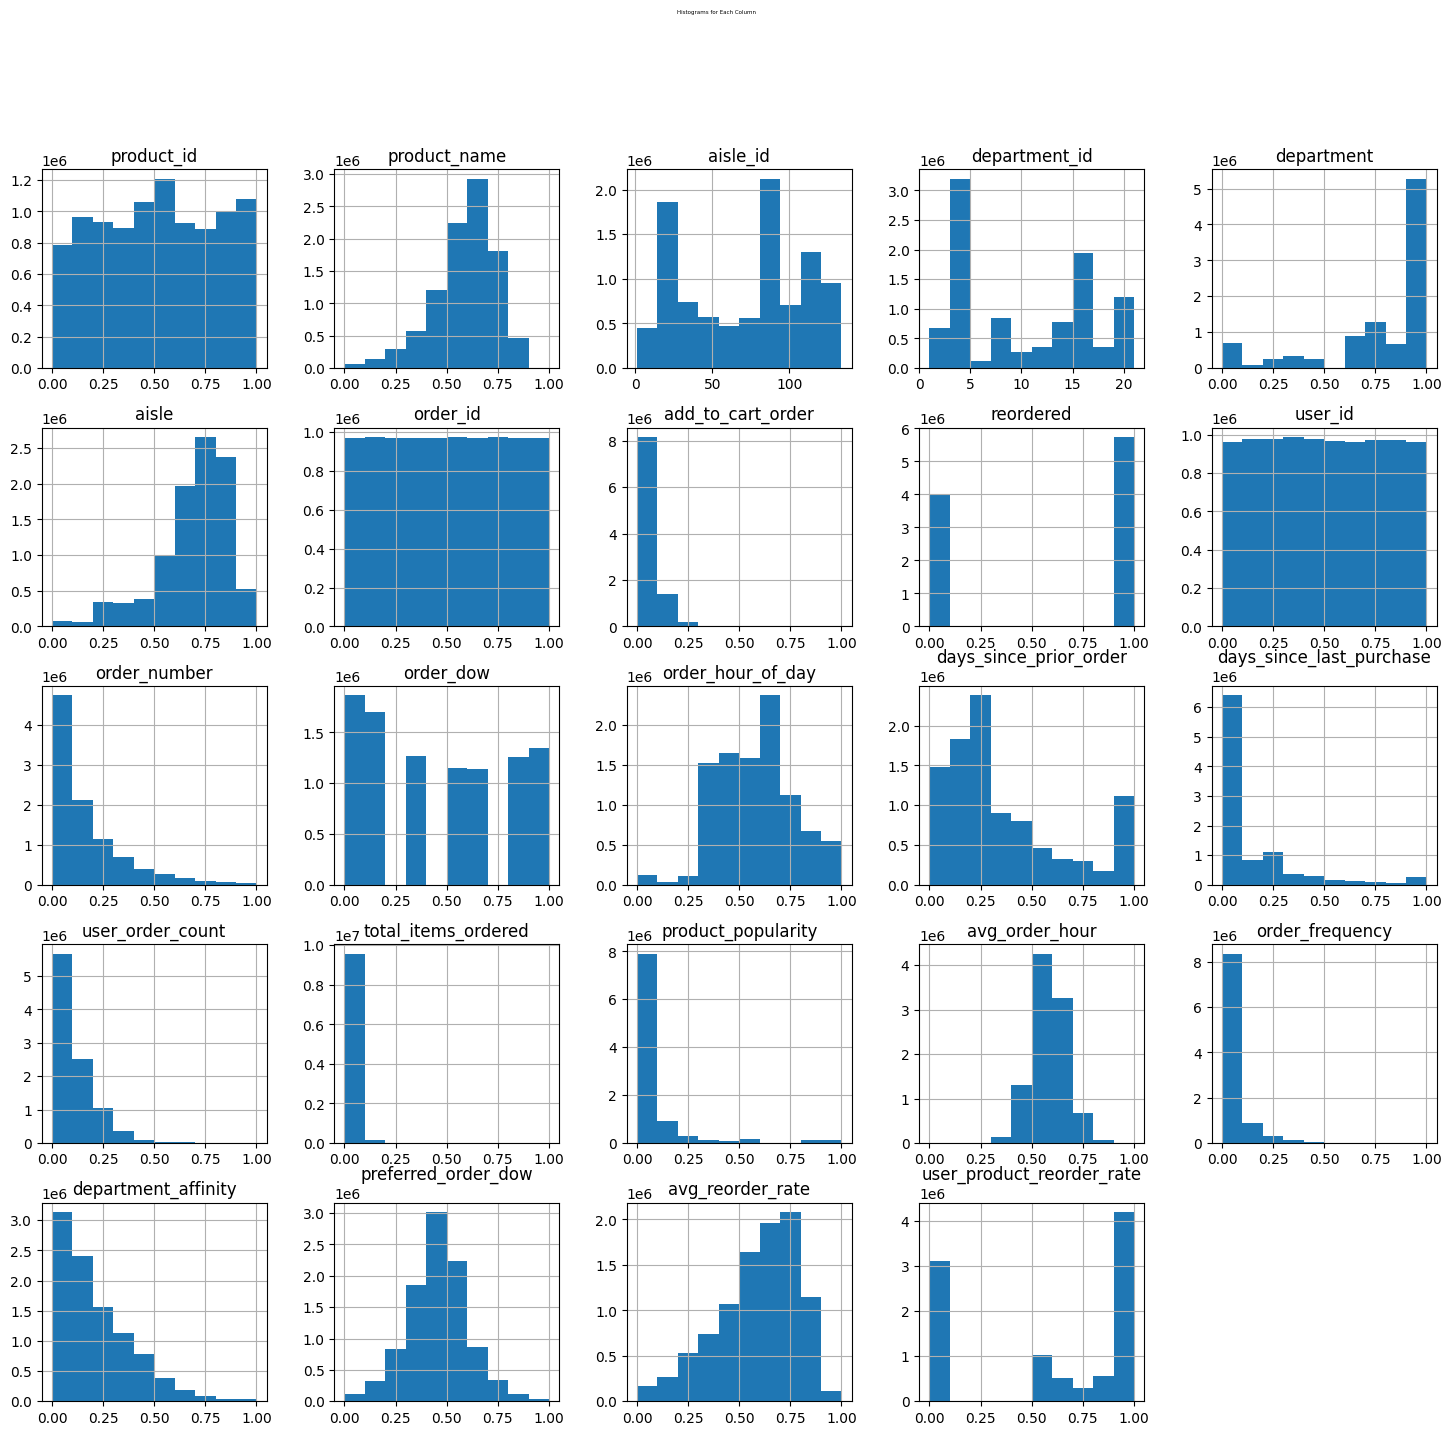

In [12]:
# Set up the plot grid
df.hist(bins=10, figsize=(18, 16), grid=True)

# Display the plot
plt.suptitle('Histograms for Each Column', fontsize=4)
plt.show()

In [13]:

# Assuming df is your DataFrame and 'reordered' is the target variable
X = df.drop(columns=['reordered'])  # Features
y = df['reordered']  # Target variable

In [14]:
# Train Logistic Regression with 'liblinear' solver
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X, y)

LogisticRegression(solver='liblinear')

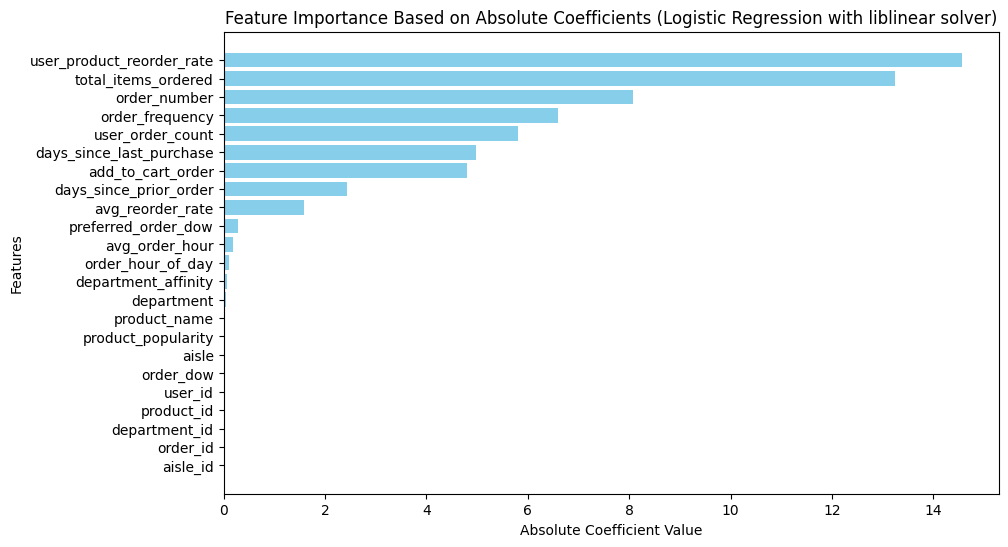

In [18]:
importance = np.abs(log_reg.coef_[0])
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance Based on Absolute Coefficients (Logistic Regression with liblinear solver)')
plt.gca().invert_yaxis()
plt.show()

In [20]:
coefficients = log_reg.coef_[0] 
feature_importances = np.abs(coefficients)  
feature_names = X.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                      Feature  Importance
22  user_product_reorder_rate   14.558618
15        total_items_ordered   13.235559
9                order_number    8.073431
18            order_frequency    6.597245
14           user_order_count    5.817680
13   days_since_last_purchase    4.988124
7           add_to_cart_order    4.804345
12     days_since_prior_order    2.429963
21           avg_reorder_rate    1.581437
20        preferred_order_dow    0.291363
17             avg_order_hour    0.187839
11          order_hour_of_day    0.107820
19        department_affinity    0.072659
4                  department    0.052107
1                product_name    0.030819
16         product_popularity    0.024981
5                       aisle    0.008111
10                  order_dow    0.007587
8                     user_id    0.005303
0                  product_id    0.003650
3               department_id    0.002395
6                    order_id    0.000584
2                    aisle_id    0

In [21]:

y_pred = log_reg.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9521


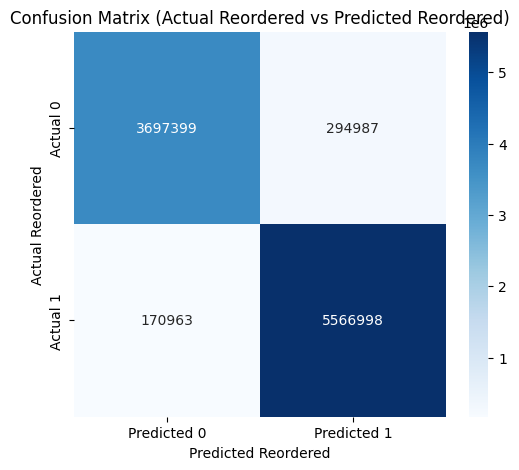

In [22]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Actual Reordered vs Predicted Reordered)')
plt.xlabel('Predicted Reordered')
plt.ylabel('Actual Reordered')
plt.show()

In [23]:
print("Classification Report:")
print(classification_report(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94   3992386
         1.0       0.95      0.97      0.96   5737961

    accuracy                           0.95   9730347
   macro avg       0.95      0.95      0.95   9730347
weighted avg       0.95      0.95      0.95   9730347



In [30]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
print(f"Top 10 features based on ANOVA F-test: {selected_features}")

Top 10 features based on ANOVA F-test: Index(['product_name', 'department', 'aisle', 'order_number',
       'days_since_last_purchase', 'user_order_count', 'product_popularity',
       'order_frequency', 'avg_reorder_rate', 'user_product_reorder_rate'],
      dtype='object')


1. **product_name**  
   - The specific product purchased has a significant influence on the target, likely due to factors like brand preferences and product characteristics.

2. **department**  
   - The department (e.g., electronics, clothing) impacts purchasing behavior, suggesting that different categories drive varying purchase patterns.

3. **aisle**  
   - The aisle (or product grouping) where a product is located is important, indicating that certain product locations may influence purchasing behavior.

4. **order_number**  
   - The number of orders a user has made correlates with customer loyalty, suggesting frequent buyers are more likely to reorder.

5. **days_since_last_purchase**  
   - The time since the last purchase is a strong predictor. Shorter gaps indicate a higher likelihood of reordering, especially for consumable products.

6. **user_order_count**  
   - A user's total order count influences the target variable. Users with higher order counts are more engaged and more likely to make repeat purchases.

7. **product_popularity**  
   - Popular products, based on sales or ratings, are likely to be reordered more, highlighting their importance in recommendations.

8. **order_frequency**  
   - Users who order more frequently are highly engaged and are more likely to make repeat purchases, indicating a strong relationship with future buying behavior.

9. **avg_reorder_rate**  
   - A higher average reorder rate indicates user satisfaction or loyalty, with these users more likely to repurchase the same products.

10. **user_product_reorder_rate**  
   - The rate at which a user reorders specific products is a key indicator of loyalty to those products and can help identify targeted recommendations or retention strategies.

In [29]:
#L1 Regularization (Lasso)** - Feature selection via Lasso
lasso = Lasso(alpha=0.01)  # Lasso regularization
lasso.fit(X, y)
lasso_selected_features = X.columns[lasso.coef_ != 0]
print(f"Selected features using Lasso regularization: {lasso_selected_features}")

Selected features using Lasso regularization: Index(['days_since_last_purchase', 'user_product_reorder_rate'], dtype='object')


 days_since_last_purchase
 The time since a user's last purchase is crucial for predicting future reorders. Shorter gaps between purchases suggest a higher likelihood of reordering, especially for consumable or replenishable products.

user_product_reorder_rate
This feature reflects how often a user reorders a specific product. A higher reorder rate indicates customer loyalty and satisfaction, making it a strong predictor for future reorders.
